In [1]:
from matplotlib import pyplot as plt
%config InlineBackend.figure_format = 'retina'

from glob import glob

import numpy as np

from tensorflow                                  import __version__
from tensorflow.test                             import is_built_with_cuda, is_gpu_available, gpu_device_name
from tensorflow.python.client                    import device_lib

from sys import version as pythonVersion
print('Python version =', pythonVersion)
from tensorflow import __version__ as tfVersion
print('Tensorflow version =', tfVersion)
from keras import __version__ as kerasVersion
print('Keras version =', kerasVersion, end='\n\n')

from tensorflow.test import is_built_with_cuda, is_gpu_available, gpu_device_name
print('\nBuilt with CUDA\t= {}\nGPU available\t= {}\nGPU device name = {}'
      .format(is_built_with_cuda(), is_gpu_available(), gpu_device_name()))
from tensorflow.python.client import device_lib
print('\nAll devices:', device_lib.list_local_devices())

from tensorflow.compat.v1                        import Session
from tensorflow.python.training.checkpoint_utils import list_variables, load_variable

from keras                 import backend as K
from keras.layers          import Activation, BatchNormalization, Bidirectional, concatenate, \
                                  Conv2D, Dense, Input, LSTM, MaxPool2D, Reshape
from keras.models          import load_model, Model

from librosa               import midi_to_hz
from sklearn.metrics       import auc, roc_curve
from sklearn.preprocessing import binarize

from note_seq.sequences_lib                             import pianoroll_to_note_sequence
from magenta.models.onsets_frames_transcription.metrics import sequence_to_valued_intervals
from mir_eval.transcription                             import precision_recall_f1_overlap as Overlap
from mir_eval.transcription_velocity                    import precision_recall_f1_overlap as OverlapVolumes

Python version = 3.8.8 (default, Feb 24 2021, 15:54:32) [MSC v.1928 64 bit (AMD64)]
Tensorflow version = 2.4.0
Keras version = 2.4.3

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.

Built with CUDA	= True
GPU available	= True
GPU device name = /device:GPU:0

All devices: [name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 557178775620714523
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3129973147
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6301289661010673912
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1050 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [2]:
dataFolder, melsMinMin, melsMinMax, melsMeanMin, melsMeanMax, melsMaxMin, melsMaxMax \
    = 'Maestro/5-20 seconds', -87, -86, -31, -30, 40, 41

melsVal = np.load(dataFolder + '/Mels validation.npy')
print(len(melsVal), 'validation samples,', end='\t')
melsValMin, melsValMean, melsValMax = melsVal.min(), melsVal.mean(), melsVal.max()
assert melsMinMin < melsValMin < melsMinMax and melsMeanMin < melsValMean < melsMeanMax \
    and melsMaxMin < melsValMax < melsMaxMax, 'Wrong mels decibels range'
print('Mels decibels in range [{:.0f} ... {:.0f} ... {:.0f}]'.format(melsValMin, melsValMean, melsValMax))

onVal, offVal, actVal, volsVal = map(np.load, ['{}/{} validation.npy'.format(
    dataFolder, name) for name in ['Onsets', 'Offsets', 'Actives', 'Volumes']])
volsValMin, volsValMean, volsValMax = volsVal.min(), volsVal.mean(), volsVal.max()
assert volsValMin == 0 and 0 < volsValMax <= 1, 'Wrong normalized MIDI volumes range'
print('Midi normalized volumes in range [{} ... {:.4f} ... {:.2f}]'.format(volsValMin, volsValMean, volsValMax))

3088 validation samples,	Mels decibels in range [-87 ... -31 ... 40]
Midi normalized volumes in range [0.0 ... 0.0033 ... 0.99]


Instead of training my own model, I just copy the weights from the Google's pre-trained tensorflow checkpoint:
https://storage.googleapis.com/magentadata/models/onsets_frames_transcription/maestro_checkpoint.zip
(or look for the link here: https://github.com/tensorflow/magenta/tree/master/magenta/models/onsets_frames_transcription)

In [3]:
cptDir, lstmWidth, inputs = 'Magenta checkpoint', 256, Input(shape=(melsVal.shape[1], melsVal.shape[2]))

ConvBnRelu = lambda n: lambda x: Activation('relu')(BatchNormalization(scale=False)(
    Conv2D(n, 3, padding='same', use_bias=False)(x)))
outputs = MaxPool2D((1, 2))(ConvBnRelu(96)(MaxPool2D((1, 2))(ConvBnRelu(48)(
    ConvBnRelu(48)(Reshape((melsVal.shape[1], melsVal.shape[2], 1))(inputs))))))

model = Model(inputs, Dense(88, activation='sigmoid')(Bidirectional(LSTM(lstmWidth,
    # https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/ops/rnn_cell_impl.py#L782
    # Sigmoid activation for hidden units, also unroll must be True, otherwise weights will be different
    # Cannot use stateful mode because backward LSTM would require reversed batch:
    recurrent_activation='sigmoid', implementation=2, return_sequences=True, unroll=True))(Dense(768, activation='relu')(
    Reshape((K.int_shape(outputs)[1], K.int_shape(outputs)[2] * K.int_shape(outputs)[3]))(outputs)))))

for i in [2, 3, 5, 6, 9, 10, 14, 15, 16]:
#    print(*model.layers[i].weights, sep='\n', end='\n\n')
    print()
    for weights in model.layers[i].weights:
        print(weights.name, weights.shape, sep='\t', end='\n')
print()
with Session() as sess: print(*['{}\t{}'.format(name, shape) for name, shape in list_variables(cptDir)], sep='\n')
model.summary()


conv2d/kernel:0	(3, 3, 1, 48)

batch_normalization/beta:0	(48,)
batch_normalization/moving_mean:0	(48,)
batch_normalization/moving_variance:0	(48,)

conv2d_1/kernel:0	(3, 3, 48, 48)

batch_normalization_1/beta:0	(48,)
batch_normalization_1/moving_mean:0	(48,)
batch_normalization_1/moving_variance:0	(48,)

conv2d_2/kernel:0	(3, 3, 48, 96)

batch_normalization_2/beta:0	(96,)
batch_normalization_2/moving_mean:0	(96,)
batch_normalization_2/moving_variance:0	(96,)

dense_1/kernel:0	(5472, 768)
dense_1/bias:0	(768,)

bidirectional/forward_lstm/lstm_cell_1/kernel:0	(768, 1024)
bidirectional/forward_lstm/lstm_cell_1/recurrent_kernel:0	(256, 1024)
bidirectional/forward_lstm/lstm_cell_1/bias:0	(1024,)
bidirectional/backward_lstm/lstm_cell_2/kernel:0	(768, 1024)
bidirectional/backward_lstm/lstm_cell_2/recurrent_kernel:0	(256, 1024)
bidirectional/backward_lstm/lstm_cell_2/bias:0	(1024,)

dense/kernel:0	(512, 88)
dense/bias:0	(88,)

beta1_power	[]
beta2_power	[]
frame/activation_probs/biases	[88]


In [4]:
def MagentaToKeras(modelName, xVal, yVal):
    numLayers, varName, varProbName = 16, modelName.lower(), None
    
    for i, j in zip(range(3), [2, 5, 9]):
        model.layers[j    ].set_weights([load_variable(cptDir, '{}/conv{}/weights'     .format(varName, i))])
        model.layers[j + 1].set_weights([load_variable(cptDir, '{}/conv{}/BatchNorm/{}'.format(varName, i, name))
                                         for name in ['beta', 'moving_mean', 'moving_variance']])
    model.layers[14].set_weights([load_variable(cptDir, '{}/fc_end/{}'.format(varName, name))
                                  for name in ['weights', 'biases']])
    
    if modelName in ['Onsets', 'Offsets']: varProbName = varName[:-1] + '_probs'
    elif modelName == 'Velocity': numLayers, varProbName = 15, 'onset_velocities'
    else:
        assert modelName == 'Frame', 'Illegal model name'
        numLayers, varProbName = 20, 'frame_probs'
        model.layers[16].set_weights([load_variable(cptDir, 'frame/activation_probs/{}'.format(name))
                                      for name in ['weights', 'biases']])

    if modelName != 'Velocity':
        fW, fB, bW, bB = [load_variable(cptDir, '{}/cudnn_lstm/stack_bidirectional_rnn/cell_0/bidirectional_rnn/'
            '{}/cudnn_compatible_lstm_cell/{}'.format(varName, fb, kb)) for fb in ['fw', 'bw'] for kb in ['kernel', 'bias']]
        # https://stackoverflow.com/questions/48212694/in-what-order-are-weights-saved-in-a-lstm-kernel-in-tensorflow
        # Tensorflow order is I-C-F-O:
        (fWi, fWc, fWf, fWo), (bWi, bWc, bWf, bWo) = map(lambda arr: np.split(arr, 4, 1), [fW, bW])
        (fBi, fBc, fBf, fBo), (bBi, bBc, bBf, bBo) = map(lambda arr: np.split(arr, 4),    [fB, bB])
        # https://stackoverflow.com/questions/47661105/order-of-lstm-weights-in-keras
        # Keras order is I-F-C-O:
        fWk, bWk, fBk, bBk = map(np.hstack, [[fWi, fWf, fWc, fWo], [bWi, bWf, bWc, bWo],
                                             [fBi, fBf, fBc, fBo], [bBi, bBf, bBc, bBo]])
        # https://stats.stackexchange.com/questions/280995/accessing-lstm-weights-tensors-in-tensorflow
        # Input units first, then hidden (recurrent) nodes:
        model.layers[numLayers - 1].set_weights([fWk[:-lstmWidth], fWk[-lstmWidth:], fBk,
                                                 bWk[:-lstmWidth], bWk[-lstmWidth:], bBk])

    model.layers[numLayers].set_weights([load_variable(cptDir, '{}/{}/{}'.format(
        varName, varProbName, name)) for name in ['weights', 'biases']])
    model.save('Magenta {} {:.2f}.hdf5'.format(modelName, model.evaluate(
        xVal, yVal, 32, 1)[1] * 100), include_optimizer=False)

def Dixon(yTrue, yPred):
    # true (correct) positives, predicted positives = tp + fp, real (ground-truth) positives = tp + fn
    tp, pp, rp = K.sum(yTrue * K.round(yPred)), K.sum(K.round(yPred)), K.sum(yTrue)
    return 1. if pp == 0 and rp == 0 else tp / (pp + rp - tp + K.epsilon())

model.compile('Adam', 'categorical_crossentropy', [Dixon])
MagentaToKeras('Onsets', melsVal, onVal)
onProb = model.predict(melsVal, 16, 1)

MagentaToKeras('Offsets', melsVal, offVal)
offProb = model.predict(melsVal, 16, 1)

def VolAcc(yTrue, yPred):
    onsets = K.cast(yTrue > K.epsilon(), float)
    yPredOnsets, numNotes = yPred * onsets, K.sum(onsets)
    
    # Linear regression:
    sumX, sumY = map(K.sum, (yPredOnsets, yTrue))
    m = (numNotes * K.sum(yPredOnsets * yTrue) - sumX * sumY) / (numNotes * K.sum(yPredOnsets ** 2) - sumX ** 2)
    yPredOnsets = (m * yPredOnsets + (sumY - m * sumX) / numNotes) * onsets
    
    return (numNotes - K.sum(K.cast(K.abs(yPredOnsets - yTrue) > .1, float))) / numNotes

model = Model(model.input, Dense(volsVal.shape[2], activation='sigmoid')(model.layers[-3].output))
model.compile('Adam', 'categorical_crossentropy', [VolAcc])
MagentaToKeras('Velocity', melsVal, volsVal)
volsProb = model.predict(melsVal, 32, 1)

onsetsIn, offsetsIn = Input(shape=(onVal.shape[1], onVal.shape[2])), Input(shape=(offVal.shape[1], offVal.shape[2]))
model = Model([onsetsIn, model.input, offsetsIn], Dense(actVal.shape[2], activation='sigmoid')(
    Bidirectional(LSTM(lstmWidth, recurrent_activation='sigmoid', implementation=2, return_sequences=True,
                       unroll=True))(concatenate([onsetsIn, model.output, offsetsIn]))))
model.compile('Adam', 'categorical_crossentropy', [Dixon])
MagentaToKeras('Frame', [onProb, melsVal, offProb], actVal)
actProb = model.predict([onProb, melsVal, offProb], 16, 1)

193/193 [==============================] - 170s 660ms/step


# Testing.

In [5]:
fps = 16_000 / 512
onsetsModel, offsetsModel, activesModel, volumesModel = map(lambda name: load_model('Magenta {}.hdf5'.format(
    name), compile=False), ['Onsets 67.72', 'Offsets 44.53', 'Frame 76.98', 'Velocity 93.40'])

for mels, onsetsTrue, offsetsTrue, activesTrue, volumesTrue in zip(*(glob(
#        '{}/test/*{}.npy'.format(dataFolder, name)) for name in ['Mels', 'Onsets', 'Offsets', 'Actives', 'Volumes'])):
        'Maestro/1-5 seconds/test/*{}.npy'.format(name)) for name in ['Mels', 'Onsets', 'Offsets', 'Actives', 'Volumes'])):
    print(' '.join(mels.split()[:-1]))
    mels, onsetsTrue, offsetsTrue, activesTrue, volumesTrue = map(lambda arr: np.load(
        arr, allow_pickle=True), [mels, onsetsTrue, offsetsTrue, activesTrue, volumesTrue])
    
    ps, rs, f1s, offPs, offRs, offF1s, volsPs, volsRs, volsF1s = [], [], [], [], [], [], [], [], []
    onTrueAll, onPredAll, onProbAll, offProbAll, actProbAll, volProbAll = None, None, [], [], [], []
    for i, [m, onTrue, offTrue, actTrue, volTrue] in enumerate(zip(mels, onsetsTrue, offsetsTrue, activesTrue, volumesTrue)):
        print('\t{} of {}'.format(i + 1, len(onsetsTrue)))

        m, onTrue, offTrue, actTrue, volTrue = map(np.array, [m, onTrue, offTrue, actTrue, volTrue])
        refIntervals, refPitches, refVolumes = sequence_to_valued_intervals(pianoroll_to_note_sequence(
            actTrue, fps, 0, onset_predictions=onTrue, offset_predictions=offTrue, velocity_values=volTrue), 0)

        m = np.pad(m, [(0, -len(m) % melsVal.shape[1]), (0, 0)], 'minimum').reshape((-1, melsVal.shape[1], melsVal.shape[2]))
        onProb, offProb, volProb = map(lambda mod: mod.predict(m, 16, 1), [onsetsModel, offsetsModel, volumesModel])
        actProb = activesModel.predict([onProb, m, offProb], 16, 1)

        onProb, offProb, actProb, volProb = map(lambda arr: np.vstack(
            arr)[:len(actTrue)], [onProb, offProb, actProb, volProb])
        onPred, offPred, actPred = map(lambda arr: binarize(arr, .5), [onProb, offProb, actProb])
        onTrueAll, onPredAll = map(lambda arr, newArr: newArr if arr is None else
            np.vstack([arr, newArr]), [onTrueAll, onPredAll], [onTrue, onPred])

        estIntervals, estPitches, estVolumes = sequence_to_valued_intervals(pianoroll_to_note_sequence(
            actPred, fps, 0, onset_predictions=onPred, offset_predictions=offPred, velocity_values=volProb), 0)
        refPitches, estPitches = map(lambda ps: midi_to_hz(ps + 21), [refPitches, estPitches])

        p, r, f1, offP, offR, offF1, volsP, volsR, volsF1 = Overlap(refIntervals, refPitches, estIntervals, estPitches,
                                  offset_ratio=None)[:-1] + Overlap(refIntervals, refPitches, estIntervals, estPitches)[:-1] \
                           + OverlapVolumes(refIntervals, refPitches, refVolumes, estIntervals, estPitches, estVolumes)[:-1]
        ps, rs, f1s, offPs, offRs, offF1s, volsPs, volsRs, volsF1s = ps + [p], rs + [r], f1s + [f1], \
            offPs + [offP], offRs + [offR], offF1s + [offF1], volsPs + [volsP], volsRs + [volsR], volsF1s + [volsF1]
    
    print('\nOnsets: \nPrecision (specificity) = {:.2%}\nRecall    (sensitivity) = {:.2%}\nF1-score                = {:.2%}\n\n'
            'Frames: \nPrecision (specificity) = {:.2%}\nRecall    (sensitivity) = {:.2%}\nF1-score                = {:.2%}\n\n'
            'Volumes:\nPrecision (specificity) = {:.2%}\nRecall    (sensitivity) = {:.2%}\nF1-score                = {:.2%}\n'
          .format(np.mean(ps), np.mean(rs), np.mean(f1s), np.mean(offPs), np.mean(offRs), np.mean(offF1s),
                  np.mean(volsPs), np.mean(volsRs), np.mean(volsF1s)))

    numOnsetsTrue, numOnsetsPred = map(lambda arr: arr.sum(1), [onTrueAll, onPredAll])
    numOnsetsTrue, numOnsetsPred = map(lambda arr: arr.sum() / len(np.nonzero(arr)[0]), [numOnsetsTrue, numOnsetsPred])
    print('Actual and predicted average number of onsets: {:.2f} {:.2f}'.format(numOnsetsTrue, numOnsetsPred))
    print('Predicts',                'more' if numOnsetsPred > numOnsetsTrue else 'less',
          'notes than actual', '(sensitive' if numOnsetsPred > numOnsetsTrue else '(specific', 'classifier)\n')
    assert abs(numOnsetsTrue - numOnsetsPred) < .1

Maestro/1-5 seconds/test\2004
	1 of 9
1/1 [==============================] - 49s 49s/step


C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\mir_eval\transcript

	2 of 9
2/2 [==============================] - 1s 528ms/step


C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\mir_eval\transcript

	3 of 9
1/1 [==============================] - 1s 682ms/step


C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\mir_eval\transcript

	4 of 9
1/1 [==============================] - 38s 38s/step


C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\mir_eval\transcript

	5 of 9
1/1 [==============================] - 0s 474ms/step


C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\mir_eval\transcript

	6 of 9
2/2 [==============================] - 1s 504ms/step


C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\mir_eval\transcript

	7 of 9
1/1 [==============================] - 1s 621ms/step


C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\mir_eval\transcript

	8 of 9
5/5 [==============================] - 3s 559ms/step


C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\mir_eval\transcript

	9 of 9
4/4 [==============================] - 2s 581ms/step


C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\mir_eval\transcript


Onsets: 
Precision (specificity) = 81.15%
Recall    (sensitivity) = 90.09%
F1-score                = 84.88%

Frames: 
Precision (specificity) = 65.05%
Recall    (sensitivity) = 71.51%
F1-score                = 67.78%

Volumes:
Precision (specificity) = 62.40%
Recall    (sensitivity) = 68.59%
F1-score                = 65.01%

Actual and predicted average number of onsets: 1.71 1.67
Predicts less notes than actual (specific classifier)

Maestro/1-5 seconds/test\2006
	1 of 11
3/3 [==============================] - 2s 520ms/step


C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\mir_eval\transcript

	2 of 11
3/3 [==============================] - 2s 519ms/step


C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\mir_eval\transcript

	3 of 11
4/4 [==============================] - 2s 627ms/step


C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\mir_eval\transcript

	4 of 11
2/2 [==============================] - 1s 576ms/step


C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\mir_eval\transcript

	5 of 11
1/1 [==============================] - 1s 541ms/step


C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\mir_eval\transcript

	6 of 11
2/2 [==============================] - 1s 430ms/step


C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\mir_eval\transcript

	7 of 11
2/2 [==============================] - 1s 448ms/step


C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\mir_eval\transcript

	8 of 11
2/2 [==============================] - 1s 439ms/step


C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\mir_eval\transcript

	9 of 11
2/2 [==============================] - 1s 519ms/step


C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\mir_eval\transcript

	10 of 11
2/2 [==============================] - 1s 466ms/step


C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\mir_eval\transcript

	11 of 11
2/2 [==============================] - 1s 403ms/step


C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\mir_eval\transcript


Onsets: 
Precision (specificity) = 80.92%
Recall    (sensitivity) = 89.34%
F1-score                = 84.76%

Frames: 
Precision (specificity) = 63.30%
Recall    (sensitivity) = 69.87%
F1-score                = 66.30%

Volumes:
Precision (specificity) = 60.67%
Recall    (sensitivity) = 66.95%
F1-score                = 63.53%

Actual and predicted average number of onsets: 1.75 1.70
Predicts less notes than actual (specific classifier)

Maestro/1-5 seconds/test\2008
	1 of 22
1/1 [==============================] - 0s 438ms/step


C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\mir_eval\transcript

	2 of 22
1/1 [==============================] - 1s 599ms/step


C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\mir_eval\transcript

	3 of 22
2/2 [==============================] - 1s 391ms/step


C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\mir_eval\transcript

	4 of 22
2/2 [==============================] - 1s 487ms/step


C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\mir_eval\transcript

	5 of 22
2/2 [==============================] - 1s 588ms/step


C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\mir_eval\transcript

	6 of 22
2/2 [==============================] - 1s 469ms/step


C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\mir_eval\transcript

	7 of 22
1/1 [==============================] - 1s 628ms/step


C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\mir_eval\transcript

	8 of 22
2/2 [==============================] - 1s 594ms/step


C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\mir_eval\transcript

	9 of 22
2/2 [==============================] - 1s 426ms/step


C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\mir_eval\transcript

	10 of 22
1/1 [==============================] - 0s 483ms/step


C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\mir_eval\transcript

	11 of 22
2/2 [==============================] - 1s 377ms/step


C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\mir_eval\transcript

	12 of 22
1/1 [==============================] - 0s 496ms/step


C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\mir_eval\transcript

	13 of 22
2/2 [==============================] - 1s 460ms/step


C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\mir_eval\transcript

	14 of 22
1/1 [==============================] - 1s 555ms/step


C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\mir_eval\transcript

	15 of 22
1/1 [==============================] - 1s 595ms/step


C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\mir_eval\transcript

	16 of 22
1/1 [==============================] - 1s 514ms/step


C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\mir_eval\transcript

	17 of 22
2/2 [==============================] - 1s 461ms/step


C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\mir_eval\transcript

	18 of 22
1/1 [==============================] - 0s 486ms/step


C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\mir_eval\transcript

	19 of 22
2/2 [==============================] - 1s 642ms/step


C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\mir_eval\transcript

	20 of 22
1/1 [==============================] - 1s 620ms/step


C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\mir_eval\transcript

	21 of 22
2/2 [==============================] - 1s 399ms/step


C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\mir_eval\transcript

	22 of 22
2/2 [==============================] - 1s 415ms/step


C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\mir_eval\transcript


Onsets: 
Precision (specificity) = 80.40%
Recall    (sensitivity) = 88.71%
F1-score                = 83.70%

Frames: 
Precision (specificity) = 65.51%
Recall    (sensitivity) = 71.74%
F1-score                = 68.01%

Volumes:
Precision (specificity) = 62.97%
Recall    (sensitivity) = 68.95%
F1-score                = 65.37%

Actual and predicted average number of onsets: 1.77 1.71
Predicts less notes than actual (specific classifier)

Maestro/1-5 seconds/test\2009
	1 of 17
1/1 [==============================] - 0s 454ms/step


C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\mir_eval\transcript

	2 of 17
2/2 [==============================] - 1s 435ms/step


C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\mir_eval\transcript

	3 of 17
2/2 [==============================] - 1s 446ms/step


C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\mir_eval\transcript

	4 of 17
2/2 [==============================] - 1s 507ms/step


C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\mir_eval\transcript

	5 of 17
3/3 [==============================] - 2s 578ms/step


C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\mir_eval\transcript

	6 of 17
6/6 [==============================] - 3s 566ms/step


C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\mir_eval\transcript

	7 of 17
5/5 [==============================] - 3s 574ms/step


C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\mir_eval\transcript

	8 of 17
2/2 [==============================] - 1s 469ms/step


C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\mir_eval\transcript

	9 of 17
1/1 [==============================] - 1s 600ms/step


C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\mir_eval\transcript

	10 of 17
3/3 [==============================] - 2s 601ms/step


C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\mir_eval\transcript

	11 of 17
5/5 [==============================] - 3s 543ms/step


C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\mir_eval\transcript

	12 of 17
1/1 [==============================] - 0s 500ms/step


C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\mir_eval\transcript

	13 of 17
1/1 [==============================] - 0s 496ms/step


C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\mir_eval\transcript

	14 of 17
3/3 [==============================] - 2s 582ms/step


C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\mir_eval\transcript

	15 of 17
5/5 [==============================] - 3s 596ms/step


C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\mir_eval\transcript

	16 of 17
2/2 [==============================] - 1s 392ms/step


C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\mir_eval\transcript

	17 of 17
2/2 [==============================] - 1s 449ms/step


C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\mir_eval\transcript


Onsets: 
Precision (specificity) = 84.51%
Recall    (sensitivity) = 92.21%
F1-score                = 88.00%

Frames: 
Precision (specificity) = 67.02%
Recall    (sensitivity) = 72.83%
F1-score                = 69.65%

Volumes:
Precision (specificity) = 63.62%
Recall    (sensitivity) = 69.17%
F1-score                = 66.13%

Actual and predicted average number of onsets: 1.60 1.58
Predicts less notes than actual (specific classifier)

Maestro/1-5 seconds/test\2011
	1 of 16
2/2 [==============================] - 1s 581ms/step


C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\mir_eval\transcript

	2 of 16
1/1 [==============================] - 1s 521ms/step


C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\mir_eval\transcript

	3 of 16
2/2 [==============================] - 1s 375ms/step


C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\mir_eval\transcript

	4 of 16
2/2 [==============================] - 1s 434ms/step


C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\mir_eval\transcript

	5 of 16
2/2 [==============================] - 1s 343ms/step


C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\mir_eval\transcript

	6 of 16
2/2 [==============================] - 1s 372ms/step


C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\mir_eval\transcript

	7 of 16
1/1 [==============================] - 1s 537ms/step


C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\mir_eval\transcript

	8 of 16
1/1 [==============================] - 1s 765ms/step


C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\mir_eval\transcript

	9 of 16
1/1 [==============================] - 1s 643ms/step


C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\mir_eval\transcript

	10 of 16
2/2 [==============================] - 1s 536ms/step


C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\mir_eval\transcript

	11 of 16
2/2 [==============================] - 1s 468ms/step


C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\mir_eval\transcript

	12 of 16
1/1 [==============================] - 1s 756ms/step


C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\mir_eval\transcript

	13 of 16
2/2 [==============================] - 1s 582ms/step


C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\mir_eval\transcript

	14 of 16
1/1 [==============================] - 1s 605ms/step


C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\mir_eval\transcript

	15 of 16
1/1 [==============================] - 1s 699ms/step


C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\mir_eval\transcript

	16 of 16
2/2 [==============================] - 1s 617ms/step


C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\mir_eval\transcript


Onsets: 
Precision (specificity) = 85.86%
Recall    (sensitivity) = 91.92%
F1-score                = 88.67%

Frames: 
Precision (specificity) = 70.27%
Recall    (sensitivity) = 75.14%
F1-score                = 72.53%

Volumes:
Precision (specificity) = 67.46%
Recall    (sensitivity) = 72.16%
F1-score                = 69.64%

Actual and predicted average number of onsets: 1.84 1.79
Predicts less notes than actual (specific classifier)

Maestro/1-5 seconds/test\2013
	1 of 10
1/1 [==============================] - 1s 624ms/step


C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\mir_eval\transcript

	2 of 10
1/1 [==============================] - 1s 643ms/step


C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\mir_eval\transcript

	3 of 10
1/1 [==============================] - 1s 564ms/step


C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\mir_eval\transcript

	4 of 10
2/2 [==============================] - 1s 591ms/step


C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\mir_eval\transcript

	5 of 10
2/2 [==============================] - 1s 580ms/step


C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\mir_eval\transcript

	6 of 10
4/4 [==============================] - 3s 668ms/step


C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\mir_eval\transcript

	7 of 10
2/2 [==============================] - 1s 501ms/step


C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\mir_eval\transcript

	8 of 10
1/1 [==============================] - 1s 658ms/step


C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\mir_eval\transcript

	9 of 10
2/2 [==============================] - 1s 521ms/step


C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\mir_eval\transcript

	10 of 10
2/2 [==============================] - 1s 621ms/step


C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\mir_eval\transcript


Onsets: 
Precision (specificity) = 82.04%
Recall    (sensitivity) = 88.30%
F1-score                = 84.99%

Frames: 
Precision (specificity) = 67.18%
Recall    (sensitivity) = 72.30%
F1-score                = 69.60%

Volumes:
Precision (specificity) = 63.77%
Recall    (sensitivity) = 68.66%
F1-score                = 66.08%

Actual and predicted average number of onsets: 2.03 1.96
Predicts less notes than actual (specific classifier)

Maestro/1-5 seconds/test\2014
	1 of 16
2/2 [==============================] - 1s 462ms/step


C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\mir_eval\transcript

	2 of 16
2/2 [==============================] - 1s 379ms/step


C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\mir_eval\transcript

	3 of 16
2/2 [==============================] - 1s 595ms/step


C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\mir_eval\transcript

	4 of 16
2/2 [==============================] - 1s 375ms/step


C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\mir_eval\transcript

	5 of 16
4/4 [==============================] - 2s 576ms/step


C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\mir_eval\transcript

	6 of 16
1/1 [==============================] - 0s 489ms/step


C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\mir_eval\transcript

	7 of 16
3/3 [==============================] - 2s 568ms/step


C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\mir_eval\transcript

	8 of 16
4/4 [==============================] - 2s 601ms/step


C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\mir_eval\transcript

	9 of 16
3/3 [==============================] - 2s 493ms/step


C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\mir_eval\transcript

	10 of 16
5/5 [==============================] - 3s 595ms/step


C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\mir_eval\transcript

	11 of 16
1/1 [==============================] - 1s 656ms/step


C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\mir_eval\transcript

	12 of 16
1/1 [==============================] - 1s 561ms/step


C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\mir_eval\transcript

	13 of 16
2/2 [==============================] - 1s 582ms/step


C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\mir_eval\transcript

	14 of 16
5/5 [==============================] - 3s 609ms/step


C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\mir_eval\transcript

	15 of 16
6/6 [==============================] - 3s 551ms/step


C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\mir_eval\transcript

	16 of 16
3/3 [==============================] - 2s 584ms/step


C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\mir_eval\transcript


Onsets: 
Precision (specificity) = 89.96%
Recall    (sensitivity) = 92.88%
F1-score                = 91.34%

Frames: 
Precision (specificity) = 70.75%
Recall    (sensitivity) = 73.00%
F1-score                = 71.81%

Volumes:
Precision (specificity) = 68.30%
Recall    (sensitivity) = 70.46%
F1-score                = 69.32%

Actual and predicted average number of onsets: 1.63 1.61
Predicts less notes than actual (specific classifier)

Maestro/1-5 seconds/test\2015
	1 of 10
1/1 [==============================] - 1s 600ms/step


C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\mir_eval\transcript

	2 of 10
2/2 [==============================] - 1s 499ms/step


C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\mir_eval\transcript

	3 of 10
1/1 [==============================] - 0s 495ms/step


C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\mir_eval\transcript

	4 of 10
1/1 [==============================] - 0s 477ms/step


C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\mir_eval\transcript

	5 of 10
1/1 [==============================] - 0s 472ms/step


C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\mir_eval\transcript

	6 of 10
2/2 [==============================] - 1s 410ms/step


C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\mir_eval\transcript

	7 of 10
2/2 [==============================] - 1s 383ms/step


C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\mir_eval\transcript

	8 of 10
3/3 [==============================] - 2s 567ms/step


C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\mir_eval\transcript

	9 of 10
2/2 [==============================] - 1s 395ms/step


C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\mir_eval\transcript

	10 of 10
1/1 [==============================] - 1s 625ms/step


C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\mir_eval\transcript


Onsets: 
Precision (specificity) = 81.63%
Recall    (sensitivity) = 92.52%
F1-score                = 86.48%

Frames: 
Precision (specificity) = 70.96%
Recall    (sensitivity) = 80.17%
F1-score                = 75.06%

Volumes:
Precision (specificity) = 66.75%
Recall    (sensitivity) = 75.42%
F1-score                = 70.61%

Actual and predicted average number of onsets: 1.71 1.68
Predicts less notes than actual (specific classifier)

Maestro/1-5 seconds/test\2017
	1 of 14
2/2 [==============================] - 1s 519ms/step


C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\mir_eval\transcript

	2 of 14
2/2 [==============================] - 1s 471ms/step


C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\mir_eval\transcript

	3 of 14
1/1 [==============================] - 1s 606ms/step


C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\mir_eval\transcript

	4 of 14
1/1 [==============================] - 0s 463ms/step


C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\mir_eval\transcript

	5 of 14
1/1 [==============================] - 1s 569ms/step


C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\mir_eval\transcript

	6 of 14
3/3 [==============================] - 2s 494ms/step


C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\mir_eval\transcript

	7 of 14
2/2 [==============================] - 1s 434ms/step


C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\mir_eval\transcript

	8 of 14
1/1 [==============================] - 1s 595ms/step


C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\mir_eval\transcript

	9 of 14
2/2 [==============================] - 1s 466ms/step


C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\mir_eval\transcript

	10 of 14
2/2 [==============================] - 1s 384ms/step


C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\mir_eval\transcript

	11 of 14
3/3 [==============================] - 2s 594ms/step


C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\mir_eval\transcript

	12 of 14
2/2 [==============================] - 1s 517ms/step


C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\mir_eval\transcript

	13 of 14
3/3 [==============================] - 2s 530ms/step


C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\mir_eval\transcript

	14 of 14
4/4 [==============================] - 2s 575ms/step


C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "



Onsets: 
Precision (specificity) = 87.06%
Recall    (sensitivity) = 93.44%
F1-score                = 90.05%

Frames: 
Precision (specificity) = 74.81%
Recall    (sensitivity) = 80.12%
F1-score                = 77.30%

Volumes:
Precision (specificity) = 71.65%
Recall    (sensitivity) = 76.72%
F1-score                = 74.03%

Actual and predicted average number of onsets: 1.72 1.67
Predicts less notes than actual (specific classifier)



C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  slope, intercept = np.linalg.lstsq(


6/6 [==============================] - 3s 554ms/step


C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.1 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.1 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.1 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\mir_eval\transcript

C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  slope, intercept = np.linalg.lstsq(
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.8 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.8 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg

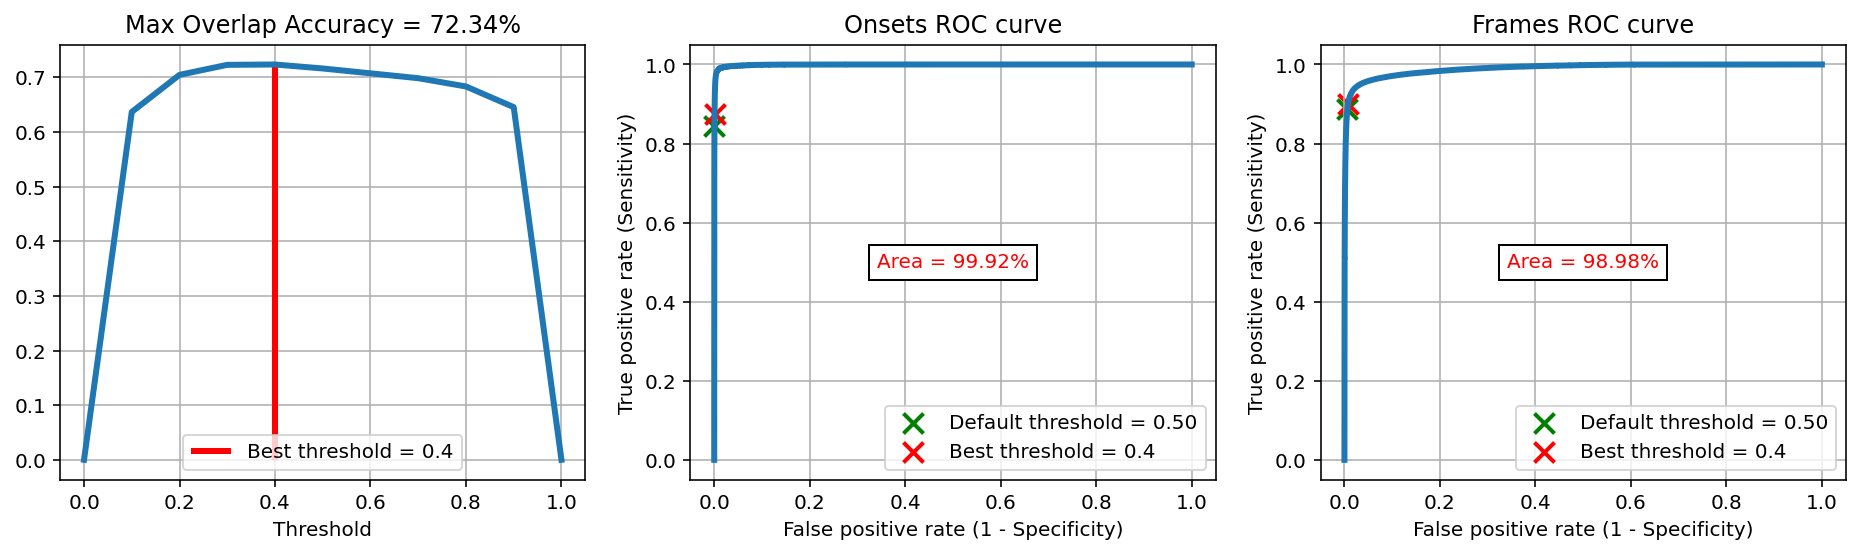

In [6]:
mels2014, onTrue2014, offTrue2014, actTrue2014, volTrue2014 = map(lambda name: np.vstack(np.load(
#    '{}/test/2014/MIDI-UNPROCESSED_19-20_R1_2014_MID--AUDIO_20_R1_2014_wav--2 {}.npy'.format(dataFolder, name),
    'Maestro/1-5 seconds/test/2014/MIDI-UNPROCESSED_19-20_R1_2014_MID--AUDIO_20_R1_2014_wav--2 {}.npy'.format(name),
    allow_pickle=True)), ['Mels', 'Onsets', 'Offsets', 'Actives', 'Volumes'])

mels2014 = np.pad(mels2014, [(0, -len(mels2014) % melsVal.shape[1]), (0, 0)],
                  'minimum').reshape((-1, melsVal.shape[1], melsVal.shape[2]))
onProb2014, offProb2014, volProb2014 = map(lambda mod: mod.predict(mels2014, 16, 1), [onsetsModel, offsetsModel, volumesModel])
actProb2014 = activesModel.predict([onProb2014, mels2014, offProb2014], 16, 1)
onProb2014, offProb2014, actProb2014, volProb2014 = map(lambda arr: np.vstack(
    arr)[:len(actTrue2014)], [onProb2014, offProb2014, actProb2014, volProb2014])

def VolumesF1(onPred, offPred, actPred):
    refIntervals, refPitches, refVolumes, estIntervals, estPitches, estVolumes = sequence_to_valued_intervals(
        pianoroll_to_note_sequence(actTrue2014, fps, 0, onset_predictions=onTrue2014, offset_predictions=offTrue2014,
            velocity_values=volTrue2014), 0) + sequence_to_valued_intervals(pianoroll_to_note_sequence(
        actPred, fps, 0, onset_predictions=onPred, offset_predictions=offPred, velocity_values=volProb2014), 0)
    refPitches, estPitches = map(lambda ps: midi_to_hz(ps + 21), [refPitches, estPitches])
    return OverlapVolumes(refIntervals, refPitches, refVolumes, estIntervals, estPitches, estVolumes)[2]


precision = 10
th = [i / precision for i in range(precision + 1)]
acc = [0] + [VolumesF1(*map(lambda arr: binarize(arr, t), [onProb2014, offProb2014, actProb2014])) for t in th[1:]]

plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)

plt.plot(th, acc, linewidth=3)
plt.title('Max Overlap Accuracy = {:.2%}'.format(max(acc)))
plt.xlabel('Threshold')

thBest = acc.index(max(acc)) / precision
plt.vlines(thBest, 0, max(acc), 'r', label='Best threshold = ' + str(thBest), linewidth=3)

plt.legend()
plt.grid()

def PlotROC(i, yTrue, yProb, name):
    plt.subplot(1, 3, i)

    fpr, tpr, ths = roc_curve(yTrue.ravel(), yProb.ravel()) # micro-average ROC curve
    plt.plot(fpr, tpr, linewidth = 3)

    plt.title(name + ' ROC curve')
    plt.xlabel('False positive rate (1 - Specificity)')
    plt.ylabel('True positive rate (Sensitivity)')

    plt.scatter(fpr[ths > .5][-1], tpr[ths > .5][-1], s=100, c='g', marker='x',
                linewidth=2, label='Default threshold = 0.50')
    plt.scatter(fpr[ths > thBest][-1], tpr[ths > thBest][-1], s=100, c='r', marker='x',
                linewidth=2, label='Best threshold = ' + str(thBest))

    plt.legend()
    plt.grid()
    plt.text(.5, .5, 'Area = {:.2%}'.format(auc(fpr, tpr)), horizontalalignment='center', verticalalignment='center',
             bbox={'facecolor': 'w', 'alpha': 1}, color='r'); # micro-average area under the ROC curve

PlotROC(2,  onTrue2014,  onProb2014, 'Onsets')
PlotROC(3, actTrue2014, actProb2014, 'Frames')

C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.4 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Evgeniy\anaconda3\envs\boris_env\lib\site-packages\sklearn\utils\valid

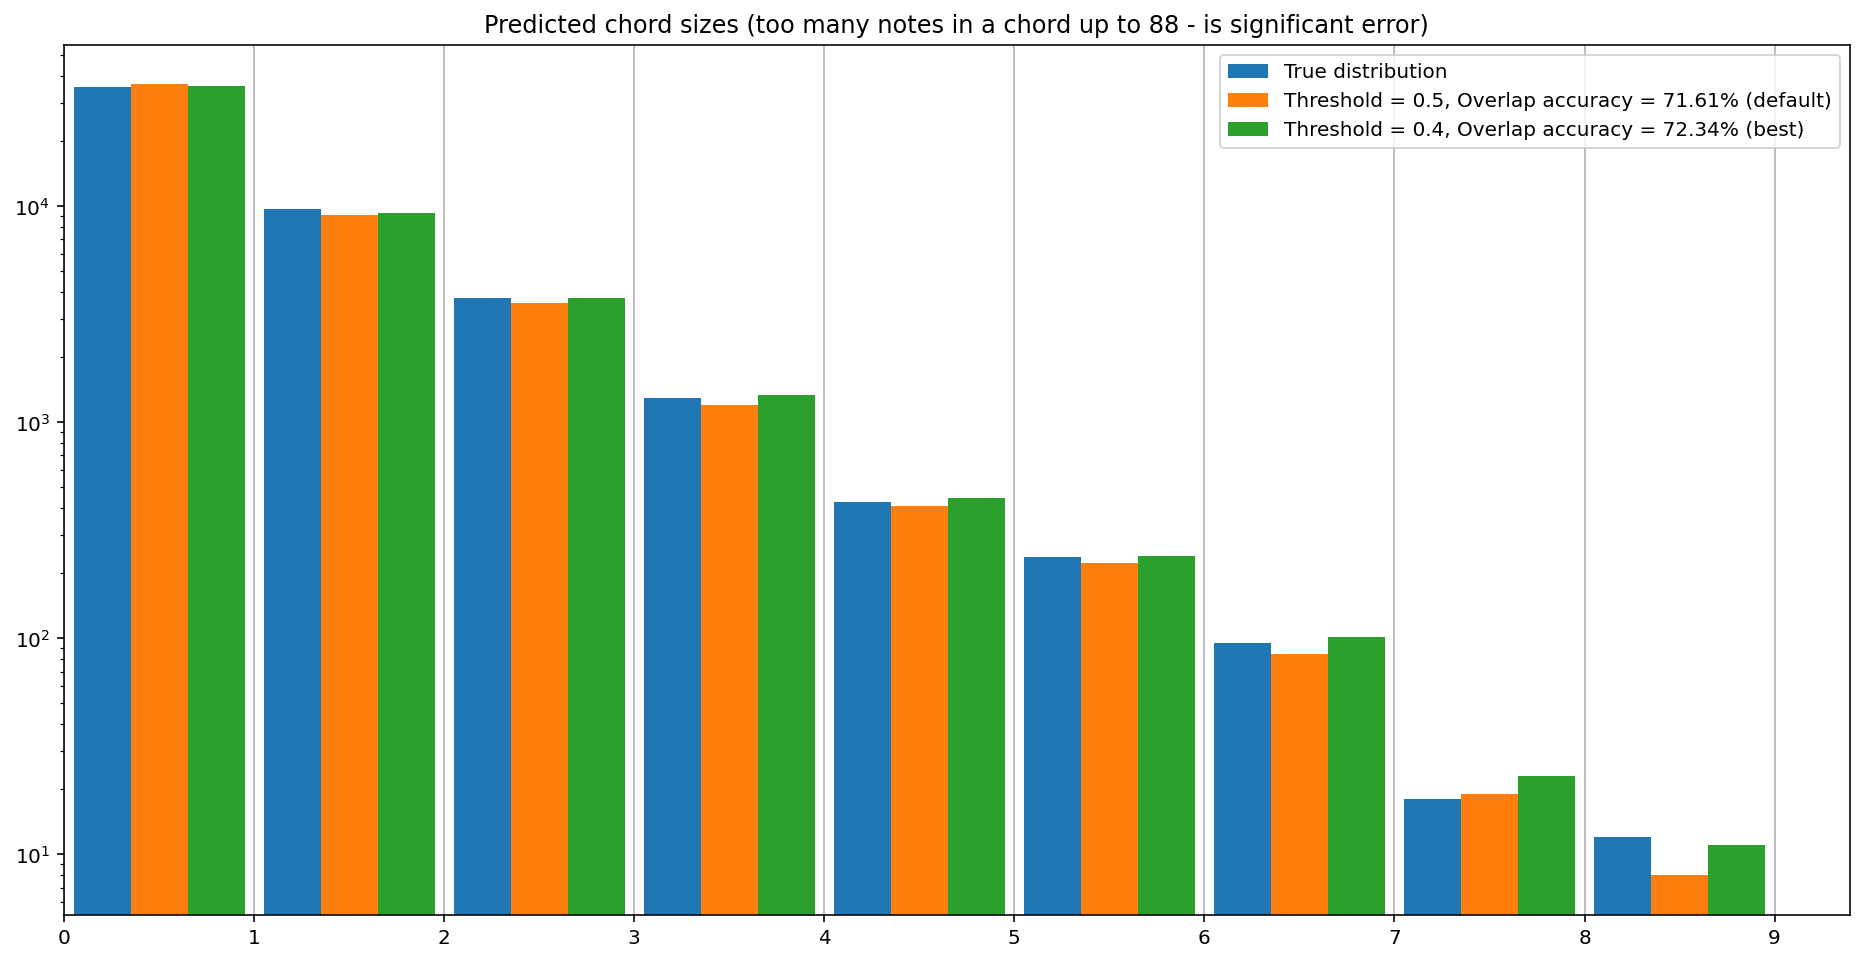

In [7]:
yPresize, yDefault = map(lambda t: binarize(onProb2014, t).astype(int), [thBest, .5])
counts = [onTrue2014.sum(1), yDefault.sum(1), yPresize.sum(1)]
maxCount = int(np.max(counts))

plt.figure(figsize=(16, 8))
plt.hist(counts, maxCount, rwidth=.9, log=True, label=['True distribution',
    'Threshold = 0.5, Overlap accuracy = {:.2%} (default)'.format(        VolumesF1(
          yDefault, binarize(offProb2014, .5),     binarize(actProb2014, .5))),
      'Threshold = {}, Overlap accuracy = {:.2%} (best)'  .format(thBest, VolumesF1(
          yPresize, binarize(offProb2014, thBest), binarize(actProb2014, thBest)))])

plt.title('Predicted chord sizes (too many notes in a chord up to 88 - is significant error)')
plt.xlim(0)
plt.xticks(range(maxCount + 1))
plt.grid(axis='x')
plt.legend();

# Keras model HDF5-file to JSON conversion<br>(without optimizer, for using just forward-pass predictions in C++):
https://github.com/Dobiasd/frugally-deep/tree/master/keras_export

In [8]:
%run convert_model.py   "Magenta Onsets 67.72.hdf5"  "Magenta Onsets.json"
print()
%run convert_model.py  "Magenta Offsets 44.53.hdf5" "Magenta Offsets.json"
print()
%run convert_model.py    "Magenta Frame 76.98.hdf5"  "Magenta Frames.json"
print()
%run convert_model.py "Magenta Velocity 93.40.hdf5" "Magenta Volumes.json"

loading Magenta Onsets 67.72.hdf5
Forward pass took 35.720829 s.
Forward pass took 0.508255 s.
Forward pass took 0.473182 s.
Starting performance measurements.
Forward pass took 0.515449 s.
Forward pass took 0.453743 s.
Forward pass took 0.437429 s.
Forward pass took 0.467689 s.
Forward pass took 0.480895 s.
Forward pass took 0.47104100000000004 s on average.
Converting model architecture.
Converting model weights.
Done converting model weights.
Calculating model hash.
Model conversion finished.
writing Magenta Onsets.json

loading Magenta Offsets 44.53.hdf5
Forward pass took 34.224986 s.
Forward pass took 0.468311 s.
Forward pass took 0.480288 s.
Starting performance measurements.
Forward pass took 0.464745 s.
Forward pass took 0.446169 s.
Forward pass took 0.41117 s.
Forward pass took 0.443116 s.
Forward pass took 0.484776 s.
Forward pass took 0.44999520000000004 s on average.
Converting model architecture.
Converting model weights.
Done converting model weights.
Calculating model ha